### 라이브러리 임포트

In [28]:
import pandas as pd
import numpy as np
import random
import os
from catboost import CatBoostRegressor, Pool

### 시드고정

In [29]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed=42
seed_everything(seed) # Seed 고정

### 데이터 불러오기 & column제거

In [30]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = df_train.drop(['sessionID','userID'],axis=1)
df_test = df_test.drop(['sessionID','userID'],axis=1)

### nan값 채우기

In [31]:
df_train.fillna('NAN', inplace=True)
df_test.fillna('NAN', inplace=True)

In [32]:
import re


df_train['new_bounced'] = df_train['new'] + df_train['bounced']
df_test['new_bounced'] = df_test['new'] + df_test['bounced']

df_train['quality/duration'] = np.where(df_train['duration'] == 0, 0, df_train['quality'] / df_train['duration'])
df_test['quality/duration'] = np.where(df_test['duration'] == 0, 0, df_test['quality'] / df_test['duration'])

df_train['duration/quality'] = np.where(df_train['quality'] == 0, 0, df_train['duration'] / df_train['quality'])
df_test['duration/quality'] = np.where(df_test['quality'] == 0, 0, df_test['duration'] / df_test['quality'])


df_train['quality/transaction'] = np.where(df_train['transaction'] == 0, 0, df_train['quality'] / df_train['transaction'])
df_test['quality/transaction'] = np.where(df_test['transaction'] == 0, 0, df_test['quality'] / df_test['transaction'])

df_train['duration/transaction'] = np.where(df_train['transaction'] == 0, 0, df_train['duration'] / df_train['transaction'])
df_test['duration/transaction'] = np.where(df_test['transaction'] == 0, 0, df_test['duration'] / df_test['transaction'])

df_train['per amount'] = np.where(df_train['transaction'] == 0, 0, df_train['transaction_revenue'] / df_train['transaction'])
df_test['per amount'] = np.where(df_test['transaction'] == 0, 0, df_test['transaction_revenue'] / df_test['transaction'])


# df_train['from'] = df_train['keyword'] + '/' + df_train['referral_path']
# df_test['from'] = df_test['keyword'] + '/' + df_test['referral_path']

# df_train['from'] = df_train['from'].str.replace('NAN', '').str.replace('/', '')
# df_test['from'] = df_test['from'].str.replace('NAN', '').str.replace('/', '')

# df_train['log_transaction_revenue'] = np.log(df_train['transaction_revenue'])
# df_test['log_transaction_revenue'] = np.log(df_test['transaction_revenue'])

# df_train['log_duration'] = np.log(df_train['duration'])
# df_test['log_duration'] = np.log(df_test['duration'])


In [33]:
# df_train.loc[df_train['traffic_source'].str.contains('google', case=False), 'traffic_source'] = 'google'
# df_test.loc[df_test['traffic_source'].str.contains('google', case=False), 'traffic_source'] = 'google'

# df_train.loc[df_train['traffic_source'].str.contains('yahoo', case=False), 'traffic_source'] = 'yahoo'
# df_test.loc[df_test['traffic_source'].str.contains('yahoo', case=False), 'traffic_source'] = 'yahoo'

# df_train.loc[df_train['traffic_source'].str.contains('youtube', case=False), 'traffic_source'] = 'youtube'
# df_test.loc[df_test['traffic_source'].str.contains('youtube', case=False), 'traffic_source'] = 'youtube'


In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1, 100))

df_train['duration'] = scaler.fit_transform(df_train[['duration']])
df_test['duration'] = scaler.transform(df_test[['duration']])

df_train['quality/duration'] = scaler.fit_transform(df_train[['quality/duration']])
df_test['quality/duration'] = scaler.transform(df_test[['quality/duration']])

df_train['duration/quality'] = scaler.fit_transform(df_train[['duration/quality']])
df_test['duration/quality'] = scaler.transform(df_test[['duration/quality']])

df_train['quality/transaction'] = scaler.fit_transform(df_train[['quality/transaction']])
df_test['quality/transaction'] = scaler.transform(df_test[['quality/transaction']])

df_train['duration/transaction'] = scaler.fit_transform(df_train[['duration/transaction']])
df_test['duration/transaction'] = scaler.transform(df_test[['duration/transaction']])

df_train['per amount'] = scaler.fit_transform(df_train[['per amount']])
df_test['per amount'] = scaler.transform(df_test[['per amount']])


In [35]:
# df_train = df_train.drop(['keyword', 'referral_path'], axis=1)
# df_test = df_test.drop(['keyword', 'referral_path'], axis=1)

df_train = df_train.drop(['continent','bounced'], axis=1)
df_test = df_test.drop(['continent','bounced'], axis=1)


In [39]:
df_train.loc[df_train['traffic_medium'] == '(none)', 'traffic_medium'] = df_train['traffic_source']
df_test.loc[df_test['traffic_medium'] == '(none)', 'traffic_medium'] = df_test['traffic_source']

df_train.loc[df_train['keyword'] == 'NAN', 'keyword'] = df_train['traffic_medium']
df_train.loc[df_train['referral_path'] == 'NAN', 'referral_path'] = df_train['traffic_medium']

df_test.loc[df_test['keyword'] == 'NAN', 'keyword'] = df_test['traffic_medium']
df_test.loc[df_test['referral_path'] == 'NAN', 'referral_path'] = df_test['traffic_medium']



In [40]:
df_train.info()
df_train.head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   TARGET                252289 non-null  float64
 1   browser               252289 non-null  object 
 2   OS                    252289 non-null  object 
 3   device                252289 non-null  object 
 4   new                   252289 non-null  int64  
 5   quality               252289 non-null  float64
 6   duration              252289 non-null  float64
 7   transaction           252289 non-null  float64
 8   transaction_revenue   252289 non-null  float64
 9   subcontinent          252289 non-null  object 
 10  country               252289 non-null  object 
 11  traffic_source        252289 non-null  object 
 12  traffic_medium        252289 non-null  object 
 13  keyword               252289 non-null  object 
 14  referral_path         252289 non-null  object 
 15  

,TARGET,browser,OS,device,new,quality,duration,transaction,transaction_revenue,subcontinent,...,traffic_source,traffic_medium,keyword,referral_path,new_bounced,quality/duration,duration/quality,quality/transaction,duration/transaction,per amount
0,17.0,Chrome,Macintosh,desktop,0,45.0,8.425443,0.0,0.0,Northern America,...,google,organic,Category8,organic,0,1.408453,1.432677,1.0,1.0,1.0
1,3.0,Chrome,Windows,desktop,1,1.0,1.345164,0.0,0.0,Western Europe,...,google,organic,Category8,organic,1,1.195266,1.905063,1.0,1.0,1.0
2,1.0,Samsung Internet,Android,mobile,1,1.0,1.000000,0.0,0.0,Southeast Asia,...,(direct),(direct),(direct),(direct),2,1.000000,1.000000,1.0,1.0,1.0
3,1.0,Chrome,Macintosh,desktop,1,1.0,1.000000,0.0,0.0,Northern America,...,Partners,affiliate,affiliate,affiliate,2,1.000000,1.000000,1.0,1.0,1.0
4,1.0,Chrome,iOS,mobile,0,1.0,1.000000,0.0,0.0,Northern America,...,groups.google.com,referral,referral,Category6_Path_0000,1,1.000000,1.000000,1.0,1.0,1.0
5,1.0,Chrome,Android,tablet,0,1.0,1.000000,0.0,0.0,Northern America,...,google,cpc,Category9,cpc,1,1.000000,1.000000,1.0,1.0,1.0
6,1.0,Chrome,Windows,desktop,1,1.0,1.000000,0.0,0.0,Southern Europe,...,youtube.com,referral,referral,Category7_Path_0001,2,1.000000,1.000000,1.0,1.0,1.0


### object type를 category type로 변경 후 label 분리

In [41]:
categorical_features = [
"browser",
"OS",
"device",
"subcontinent",
"country",
"traffic_source",
"traffic_medium",
'keyword', 
'referral_path'
]
for i in categorical_features:
    df_train[i] = df_train[i].astype('category')
    df_test[i] = df_test[i].astype('category')

x_train = df_train.drop('TARGET', axis=1)
y_train = df_train['TARGET']
train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)

### 모델 정의 후 학습

In [42]:
clf = CatBoostRegressor(random_state=seed, verbose=False)
clf.fit(train_pool)

### 테스트 데이터 예측

In [43]:
test_pool = Pool(data=df_test, cat_features=categorical_features)
pred = clf.predict(test_pool)
pred

array([27.84149461,  1.02032729,  2.67091399, ...,  2.58598422,
        4.71000193,  1.03800345])

Text(0.5, 1.0, 'Feature Importance')

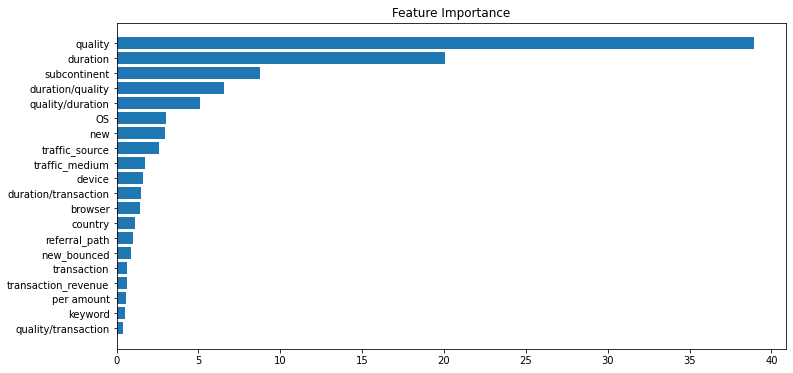

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns


feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title('Feature Importance')


### 0보다 작은 값 보정

In [45]:
pred = [1 if i < 1 else i for i in pred]


### csv파일에 예측값 입력 후 제출

In [46]:
df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred

In [47]:
df_submit.head()

,sessionID,TARGET
0,SESSION_252289,27.841495
1,SESSION_252290,1.020327
2,SESSION_252291,2.670914
3,SESSION_252292,4.311597
4,SESSION_252293,10.568730


In [48]:
df_submit.to_csv("sample_submission.csv", index=False)